In [1]:
import pandas as pd

# Load the dataset from the GitHub repository
url = 'https://raw.githubusercontent.com/gregversteeg/LinearCorex/master/tests/data/test_big5.csv'
df = pd.read_csv(url)

# Display basic information about the dataset
print("Number of instances in the dataset:", df.shape[0])
print("Number of columns in the dataset:", df.shape[1])
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Display additional information
print("\nData Types and Non-Null Counts:")
print(df.info())

Number of instances in the dataset: 2000
Number of columns in the dataset: 50

First 5 rows of the dataset:
   blue_q0  red_q1  green_q2  purple_q3  q4  blue_q5  red_q6  green_q7  \
0        2       0         3          1   4        1       4         1   
1        2       0         1          2   2        1       4         3   
2        3       0         2          1   3        1       4         3   
3        2       0         1          1   1        0       4         1   
4        2       0         1          1   3        0       4         3   

   purple_q8  q9  ...  blue_q40  red_q41  green_q42  purple_q43  q44  \
0          2   2  ...         3        3          3           2    3   
1          3   1  ...         2        3          2           2    3   
2          3   0  ...         4        4          2           1    4   
3          3   1  ...         1        2          2           1    3   
4          2   0  ...         3        4          1           3    4   

   blue_q45  r

In [2]:
df = df / 4.0
# print(df.head())

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Split the data into features (X) and target (Y) if necessary.
# In the case of autoencoder-like models, we do not have target Y, so we'll treat the whole dataset as X.
X = df.values  # Convert the DataFrame into a NumPy array for model input

# Split the dataset into training (80%) and testing sets (20%)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Output the shapes to verify
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1600, 50)
Test set shape: (400, 50)


In [4]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert the DataFrame to a NumPy array
data_array = df.to_numpy()

# Convert the data to a PyTorch tensor
data_tensor = torch.tensor(data_array, dtype=torch.float32)

# Create a PyTorch dataset
dataset = TensorDataset(data_tensor)

# Split the dataset into training and validation sets (80-20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for the training and validation sets
batch_size = 32  # You can adjust the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Display the shape of the tensor to verify
print(f"Data tensor shape: {data_tensor.shape}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Data tensor shape: torch.Size([2000, 50])
Number of training batches: 50
Number of validation batches: 13


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, adjusted_rand_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, encoder_hidden_dims=[]):
        super(Autoencoder, self).__init__()

        # Build the encoder
        encoder_dims = [input_dim] + encoder_hidden_dims + [latent_dim]
        encoder_layers = []
        for i in range(len(encoder_dims) - 1):
            encoder_layers.append(nn.Linear(encoder_dims[i], encoder_dims[i + 1]))
            if i < len(encoder_dims) - 2:
                encoder_layers.append(nn.ReLU())  # Activation function between hidden layers
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder: Linear layer from latent_dim to input_dim
        self.decoder = nn.Linear(latent_dim, input_dim)

    def forward(self, x):
        z = self.encoder(x)    # Latent representation
        x_hat = self.decoder(z)  # Reconstructed input
        return x_hat

In [6]:
input_dim = X_train.shape[1]  # Number of features (should be 50)
latent_dim = 5
encoder_hidden_dims = [256,128,64,32]                 # Number of latent variables (matching the known factors)

# Instantiate the model
model = Autoencoder(input_dim, latent_dim, encoder_hidden_dims)

# Define the loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Define the optimizer (Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, adjusted_rand_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F


num_epochs = 100

# Initialize a list to store attention matrices for each epoch
attention_matrices = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for data in train_loader:
        x = data[0]
        optimizer.zero_grad()
        x_hat = model(x)
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)  # Accumulate loss

    train_loss /= len(train_loader.dataset)

    # Evaluate on validation data
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            x = data[0]
            x_hat = model(x)
            loss = criterion(x_hat, x)
            test_loss += loss.item() * x.size(0)
    test_loss /= len(val_loader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')

    # Extract the decoder weights at the end of each epoch
    decoder_weights = model.decoder.weight.data.numpy()  # Shape: (input_dim, latent_dim)

    # Compute the attention matrix
    abs_decoder_weights = np.abs(decoder_weights)  # Take absolute values

    # Apply softmax over latent_dim axis (dim=1)
    abs_decoder_weights_tensor = torch.tensor(abs_decoder_weights, dtype=torch.float32)
    attention_matrix_tensor = F.softmax(abs_decoder_weights_tensor, dim=1)  # Shape: (input_dim, latent_dim)

    # Convert back to NumPy array
    attention_matrix = attention_matrix_tensor.numpy()

    # Transpose the matrix to have latent factors along y-axis and observed variables along x-axis
    attention_matrix = attention_matrix.T  # Shape: (latent_dim, input_dim)

    # Append the attention matrix to the list
    attention_matrices.append(attention_matrix)

Epoch [1/100], Train Loss: 0.087159, Test Loss: 0.085036
Epoch [2/100], Train Loss: 0.085651, Test Loss: 0.083592
Epoch [3/100], Train Loss: 0.084469, Test Loss: 0.082162
Epoch [4/100], Train Loss: 0.080798, Test Loss: 0.077293
Epoch [5/100], Train Loss: 0.073271, Test Loss: 0.069671
Epoch [6/100], Train Loss: 0.068189, Test Loss: 0.065383
Epoch [7/100], Train Loss: 0.063082, Test Loss: 0.061585
Epoch [8/100], Train Loss: 0.060947, Test Loss: 0.060260
Epoch [9/100], Train Loss: 0.060418, Test Loss: 0.059867
Epoch [10/100], Train Loss: 0.057906, Test Loss: 0.057393
Epoch [11/100], Train Loss: 0.054987, Test Loss: 0.054622
Epoch [12/100], Train Loss: 0.053208, Test Loss: 0.053608
Epoch [13/100], Train Loss: 0.052969, Test Loss: 0.053768
Epoch [14/100], Train Loss: 0.052602, Test Loss: 0.052940
Epoch [15/100], Train Loss: 0.052668, Test Loss: 0.053150
Epoch [16/100], Train Loss: 0.052370, Test Loss: 0.053133
Epoch [17/100], Train Loss: 0.052400, Test Loss: 0.052941
Epoch [18/100], Train L

In [9]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display, Video
import numpy as np

# Stack the attention matrices into a 3D NumPy array
attention_matrices_array = np.stack(attention_matrices)  # Shape: (num_epochs, latent_dim, input_dim)

# Determine the number of frames (epochs)
num_frames = attention_matrices_array.shape[0]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Initialize the heatmap with empty data
im = ax.imshow(np.zeros_like(attention_matrices_array[0]), aspect='auto', cmap='viridis', vmin=0, vmax=1)
ax.set_xlabel('Observed Variables')
ax.set_ylabel('Latent Factors')
title = ax.set_title('Attention Matrix at Epoch 0')

# Function to initialize the heatmap
def init():
    data = attention_matrices_array[0]
    im.set_data(data)
    title.set_text('Attention Matrix at Epoch 1')
    return [im, title]

# Function to update the heatmap for each frame
def update(frame):
    data = attention_matrices_array[frame]
    im.set_data(data)
    title.set_text(f'Attention Matrix at Epoch {frame + 1}')
    return [im, title]

# Create the animation
ani = FuncAnimation(fig, update, frames=num_frames, init_func=init, blit=True)

# Close the figure to prevent the static plot from displaying
plt.close(fig)

# Display the animation in the notebook
display(HTML(ani.to_jshtml()))

# Save the animation to an MP4 file
ani.save('attention_animation.mp4', writer='ffmpeg', fps=2)

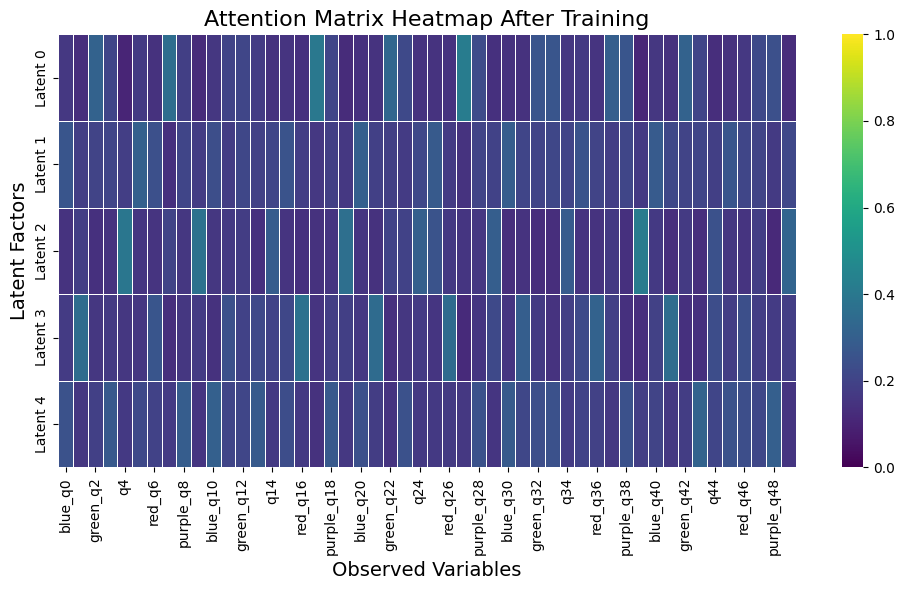

In [12]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the decoder weights after training
decoder_weights = model.decoder.weight.data.numpy()  # Shape: (input_dim, latent_dim)

# Compute the attention matrix in the same way as during training
abs_decoder_weights = np.abs(decoder_weights)  # Take absolute values

# Convert to tensor for softmax computation
abs_decoder_weights_tensor = torch.tensor(abs_decoder_weights, dtype=torch.float32)

# Apply softmax over latent_dim axis (dim=1)
attention_matrix_tensor = F.softmax(abs_decoder_weights_tensor, dim=1)  # Shape: (input_dim, latent_dim)

# Convert back to NumPy array
attention_matrix = attention_matrix_tensor.numpy()  # Shape: (input_dim, latent_dim)

# Transpose the attention matrix to have latent factors along y-axis and observed variables along x-axis
attention_matrix = attention_matrix.T  # Shape: (latent_dim, input_dim)

# Prepare labels for observed variables and latent factors
observed_variable_names = df.columns.tolist()  # List of observed variable names
latent_factor_names = [f'Latent {i}' for i in range(latent_dim)]  # Latent factor names

# Create a DataFrame for visualization
attention_df = pd.DataFrame(
    attention_matrix,
    index=latent_factor_names,
    columns=observed_variable_names
)

# Plot the attention matrix heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    attention_df,
    cmap='viridis',
    linewidths=0.5,
    annot=False,
    cbar=True,
    vmin=0,
    vmax=1
)
plt.title('Attention Matrix Heatmap After Training', fontsize=16)
plt.xlabel('Observed Variables', fontsize=14)
plt.ylabel('Latent Factors', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()